In [2]:
# Janky xgboost fix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import pandas as pd
import numpy as np
import re
import os.path
import xgboost as xgb
import imblearn.over_sampling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from code.lw_pickle import var_to_pickle, read_pickle
from code.lw_val_by_group import cross_val_by_group, train_test_by_group

%matplotlib inline

### Load Data

In [4]:
order_path = '../data/subset/'
common_path = '../data/common/'

In [5]:
orders_df = pd.read_csv(os.path.join(order_path, 'orders.csv'))
orders_df.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   1363380       50    prior             1          3                  9   
1   3131103       50    prior             2          6                 12   
2   2197066       50    prior             3          1                 13   
3   3201640       50    prior             4          0                 11   
4   2756806       50    prior             5          4                 14   

   days_since_prior_order  
0                     NaN  
1                    10.0  
2                     9.0  
3                     6.0  
4                    11.0

In [6]:
orders_prior_df = pd.read_csv(os.path.join(order_path, 'order_products__prior.csv'))
orders_prior_df.head()

order_id  product_id  add_to_cart_order  reordered
0        12       30597                  1          1
1        12       15221                  2          1
2        12       43772                  3          1
3        12       37886                  4          1
4        12       37215                  5          0

In [7]:
orders_train_df = pd.read_csv(os.path.join(order_path, 'order_products__train.csv'))
orders_train_df.head()

order_id  product_id  add_to_cart_order  reordered
0      1077       13176                  1          1
1      1077       39922                  2          1
2      1077        5258                  3          1
3      1077       21137                  4          1
4      1119        6046                  1          1

In [8]:
depts_df = pd.read_csv(os.path.join(common_path, 'departments.csv'))
depts_df.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [9]:
aisles_df = pd.read_csv(os.path.join(common_path, 'aisles.csv'))
aisles_df.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [10]:
products_df = pd.read_csv(os.path.join(common_path, 'products.csv'))
products_df.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

### Merge Product Dataframes

In [11]:
products_df = products_df.merge(aisles_df, how='left', on='aisle_id')
products_df = products_df.merge(depts_df, how='left', on='department_id')
products_df.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
products_df.head()

product_id                                       product_name  \
0           1                         Chocolate Sandwich Cookies   
1           2                                   All-Seasons Salt   
2           3               Robust Golden Unsweetened Oolong Tea   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4           5                          Green Chile Anytime Sauce   

                        aisle department  
0               cookies cakes     snacks  
1           spices seasonings     pantry  
2                         tea  beverages  
3                frozen meals     frozen  
4  marinades meat preparation     pantry

In [12]:
orders_prior_df = orders_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_train_df = orders_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_train_df.head()

order_id  product_id  add_to_cart_order  reordered  user_id  order_number  \
0      1077       13176                  1          1   173934            11   
1      1077       39922                  2          1   173934            11   
2      1077        5258                  3          1   173934            11   
3      1077       21137                  4          1   173934            11   
4      1119        6046                  1          1   129386             7   

   order_dow  order_hour_of_day  days_since_prior_order  
0          6                  9                    10.0  
1          6                  9                    10.0  
2          6                  9                    10.0  
3          6                  9                    10.0  
4          1                 14                    17.0

In [16]:
df = orders_train_df.merge(products_df, how='left', on='product_id')
df[df['user_id'] == 55976]

order_id  product_id  add_to_cart_order  reordered  user_id  \
40422   2569310       22046                  1          1    55976   
40423   2569310        5258                  2          1    55976   
40424   2569310       26348                  3          1    55976   

       order_number  order_dow  order_hour_of_day  days_since_prior_order  \
40422             9          5                  8                    30.0   
40423             9          5                  8                    30.0   
40424             9          5                  8                    30.0   

                    product_name                          aisle department  
40422  Frozen Whole Strawberries                 frozen produce     frozen  
40423            Sparkling Water  water seltzer sparkling water  beverages  
40424   Mixed Fruit Fruit Snacks         fruit vegetable snacks     snacks

In [14]:
orders_prior_df['order_id'].nunique() + orders_train_df['order_id'].nunique()

82683

### Merge Cart-level DataFrame

In [12]:
df = (orders_prior_df.groupby(['product_id', 'user_id'], as_index=False)
                     .agg({'order_id':'nunique'})
                     .rename(columns={'order_id':'count_in_user_orders'}))
train_users = orders_train_df['user_id'].unique()
df = df[df['user_id'].isin(train_users)]
df.reset_index(drop=True, inplace=True)

### Feature Engineering

#### Target: Whether or Not Product is in Cart

In [13]:
train_carts_df = (orders_train_df.groupby('user_id')
                                 .agg({'product_id':(lambda x: set(x))})
                                 .rename(columns={'product_id':'cart_contents'}))

df = df.merge(train_carts_df, on='user_id')
df['in_cart'] = (df.apply(lambda row: row['product_id'] in row['cart_contents'], axis=1)
                   .astype(int))
df.drop('cart_contents', axis=1, inplace=True)

#### Feature: Product Order Rate by User

In [14]:
prior_per_user_df = (orders_prior_df.groupby(['user_id'])[['order_id']]
                                    .nunique()
                                    .rename(columns={'order_id':'total_user_orders'}))
df = df.merge(prior_per_user_df, on='user_id')
df['percent_in_user_orders'] = df['count_in_user_orders'] / df['total_user_orders']
df.drop(['count_in_user_orders'], axis=1, inplace=True)

#### Feature: Product Overall Order Rate

In [15]:
product_prior_df = (orders_prior_df.groupby(['product_id'], as_index=False)
                                   .agg({'order_id':'nunique'})
                                   .rename(columns={'order_id':'count_in_all_orders'})
                                   .sort_values(by=['count_in_all_orders'], ascending=False)
                                   .reset_index(drop=True))
num_orders = orders_prior_df['order_id'].nunique()
product_prior_df['percent_in_all_orders'] = (product_prior_df['count_in_all_orders'] /
                                             num_orders)
product_prior_df.drop('count_in_all_orders', axis=1, inplace=True)
df = df.merge(product_prior_df, on='product_id')

#### Feature: In Last Cart

In [16]:
mask = (orders_prior_df.sort_values(by='order_number')
                       .groupby(['user_id'])['order_id']
                       .last())
last_contents_df = (orders_prior_df[orders_prior_df['order_id'].isin(mask)]
                    .groupby(['user_id'])['product_id'].unique())
last_contents_df = pd.DataFrame(last_contents_df)
last_contents_df.rename(columns={'product_id':'last_cart_contents'}, inplace=True)

df = df.merge(last_contents_df, how='left', on='user_id')
df['in_last_cart'] =\
    (df.apply(lambda row: row['product_id'] in row['last_cart_contents'], axis=1)
       .astype(int))
df.drop('last_cart_contents', axis=1, inplace=True)

#### Feature: Days/Orders Between Orders, Times Product Appears in Last 5 Orders

In [17]:
since_first_df = (orders_prior_df.groupby(['user_id', 'order_id'], as_index=False)
                                 .agg({'order_number':'first',
                                       'days_since_prior_order':'first'}))
since_first_df = (since_first_df.drop('days_since_prior_order', axis=1)
                                .merge(since_first_df.drop('order_id', axis=1),
                                                           how='left',
                                                           on='user_id'))

mask = since_first_df['order_number_x'] <= since_first_df['order_number_y']
since_newest_df = since_first_df[mask].drop(['user_id', 'order_number_y'], axis=1)
since_newest_df = (since_newest_df.groupby(['order_id', 'order_number_x'],
                                           as_index=False)['days_since_prior_order'].sum())
since_newest_df.drop('order_number_x', axis=1, inplace=True)
since_newest_df.rename(columns={'days_since_prior_order':'days_since_newest'}, inplace=True)

mask = since_first_df['order_number_x'] >= since_first_df['order_number_y']
since_first_df = since_first_df[mask].drop(['user_id', 'order_number_y'], axis=1)
since_first_df = (since_first_df.groupby(['order_id', 'order_number_x'],
                                         as_index=False)['days_since_prior_order'].sum())
since_first_df.rename(columns={'days_since_prior_order':'days_since_first_order',
                               'order_number_x':'order_number'}, inplace=True)

newest_cart_df =\
    (orders_train_df.groupby(['user_id'])[['order_number', 'days_since_prior_order']]
                    .first()
                    .rename(columns={'order_number':'newest_order_number'}))

In [18]:
orders_since_df = orders_prior_df[['user_id', 'order_id', 'product_id']]
orders_since_df = orders_since_df.merge(since_first_df, how='left', on='order_id')
orders_since_df = orders_since_df.merge(since_newest_df, how='left', on='order_id')
orders_since_df = orders_since_df.merge(newest_cart_df, how='left', on='user_id')

orders_since_df['days_since_newest'] += orders_since_df['days_since_prior_order']
orders_since_df['orders_since_newest'] = (orders_since_df['newest_order_number'] -
                                          orders_since_df['order_number'])

mask = orders_since_df['order_number'] >= (orders_since_df['newest_order_number'] - 5)
last_five_df =\
    (orders_since_df[mask].groupby(['user_id', 'product_id'], as_index=False)['order_id']
                          .count()
                          .rename(columns={'order_id':'in_last_five'}))
orders_since_df = orders_since_df.merge(last_five_df,
                                        how='left',
                                        on=['user_id', 'product_id'])
orders_since_df['in_last_five'] = orders_since_df['in_last_five'].fillna(0).astype(int)

In [19]:
orders_since_df.sort_values(by=['user_id', 'product_id', 'order_number'], inplace=True)
orders_since_df.reset_index(drop=True, inplace=True)

orders_since_df['last_order_number'] =\
    orders_since_df.groupby(['user_id', 'product_id'])['order_number'].shift(1)
orders_since_df['last_days_since_first_order'] =\
    orders_since_df.groupby(['user_id', 'product_id'])['days_since_first_order'].shift(1)
orders_since_df['mean_orders_between'] =\
    orders_since_df['order_number'] - orders_since_df['last_order_number']
orders_since_df['mean_days_between'] =\
    orders_since_df['days_since_first_order'] - orders_since_df['last_days_since_first_order']

(orders_since_df['mean_orders_between'].fillna(orders_since_df['orders_since_newest'],
                                               inplace=True))
(orders_since_df['mean_days_between'].fillna(orders_since_df['days_since_newest'],
                                             inplace=True))

orders_since_df = (orders_since_df.groupby(['user_id', 'product_id'], as_index=False)
                                  .agg({'mean_orders_between':'mean',
                                        'mean_days_between':'mean',
                                        'orders_since_newest':'last',
                                        'days_since_newest':'last',
                                        'in_last_five':'last'}))
orders_since_df.rename({'order_number':'lastest_order_number'}, inplace=True)

In [20]:
df = df.merge(orders_since_df, how='left', on=['user_id', 'product_id'])

#### Feature: Likelihood a Product Gets Reordered

In [21]:
product_proba_df = (orders_prior_df.groupby('product_id', as_index=False)
                                   .agg({'user_id':'nunique', 'order_id':'count'}))
product_proba_df['product_reorder_proba'] = 1 - (product_proba_df['user_id'] /
                                                 product_proba_df['order_id'])
product_proba_df.drop(['user_id', 'order_id'], axis=1, inplace=True)
df = df.merge(product_proba_df, how='left', on='product_id')

#### Feature: Likelihood a User Reorders Any Product

In [22]:
user_proba_df = (orders_prior_df.groupby('user_id', as_index=False)
                                .agg({'product_id':'nunique', 'order_id':'count'}))
user_proba_df['user_reorder_proba'] = 1 - (user_proba_df['product_id'] /
                                           user_proba_df['order_id'])
user_proba_df.drop(['product_id', 'order_id'], axis=1, inplace=True)
df = df.merge(user_proba_df, how='left', on='user_id')

#### Feature: Average Hour of Week, Order Size, and Add Order Percentile for Prior Orders

In [23]:
hour_of_week_df = (orders_prior_df.groupby('order_id')
                                  .agg({'order_dow':'first',
                                        'order_hour_of_day':'first',
                                        'add_to_cart_order':'max'})
                                  .rename(columns={'add_to_cart_order':'mean_cart_size'}))
hour_of_week_df['mean_hour_of_week'] = (hour_of_week_df['order_dow'] * 24 +
                                        hour_of_week_df['order_hour_of_day'])
hour_of_week_df.drop(['order_dow', 'order_hour_of_day'], axis=1, inplace=True)

percentile_df = (orders_prior_df[['user_id', 'order_id', 'product_id', 'add_to_cart_order']]
                 .merge(hour_of_week_df, how='left', on='order_id'))
percentile_df['mean_cart_percentile'] = (1 - (percentile_df['add_to_cart_order'] - 1) /
                                         percentile_df['mean_cart_size'])
percentile_df = (percentile_df.groupby(['user_id', 'product_id'])
                              .agg({'mean_cart_size':'mean',
                                    'mean_cart_percentile':'mean',
                                    'mean_hour_of_week':'mean'}))

df = df.merge(percentile_df, how='left', on=['user_id', 'product_id'])

#### Feature: Hour of Week and Number of Items in Newest Order

In [24]:
hour_of_week_df = (orders_train_df.groupby('user_id')
                                  .agg({'order_dow':'first',
                                        'order_hour_of_day':'first',
                                        'add_to_cart_order':'max'})
                                  .rename(columns={'add_to_cart_order':'newest_cart_size'}))
hour_of_week_df['newest_hour_of_week'] = (hour_of_week_df['order_dow'] * 24 +
                                          hour_of_week_df['order_hour_of_day'])
hour_of_week_df.drop(['order_dow', 'order_hour_of_day'], axis=1, inplace=True)

df = df.merge(hour_of_week_df, how='left', on=['user_id'])

#### Feature: Absolute Difference in Cart Size, Hour of Week, Hour, and Day

In [25]:
df['cart_size_difference'] = np.abs(df['mean_cart_size'] - df['newest_cart_size'])
df['hour_of_week_difference'] = np.abs(df['mean_hour_of_week'] - df['newest_hour_of_week'])

#### Check All Features

In [26]:
df.describe()

product_id        user_id        in_cart  total_user_orders  \
count  329806.000000  329806.000000  329806.000000      329806.000000   
mean    25478.038332  102584.627005       0.098055          24.931824   
std     14236.306598   59451.330080       0.297389          21.717598   
min         1.000000      50.000000       0.000000           3.000000   
25%     13249.000000   50828.000000       0.000000           9.000000   
50%     25555.500000  103434.000000       0.000000          18.000000   
75%     38100.000000  154426.000000       0.000000          34.000000   
max     49683.000000  206175.000000       1.000000          99.000000   

       percent_in_user_orders  percent_in_all_orders   in_last_cart  \
count           329806.000000          329806.000000  329806.000000   
mean                 0.153016               0.007014       0.160091   
std                  0.163067               0.017098       0.366691   
min                  0.010101               0.000013       0.000000   
25%                  0.045455               0.000348       0.000000   
50%                  0.093750               0.001365       0.000000   
75%                  0.200000               0.005085       0.000000   
max                  1.000000               0.140970       1.000000   

       mean_orders_between  mean_days_between  orders_since_newest  \
count        329806.000000      329806.000000        329806.000000   
mean             10.619449         109.261218            10.385275   
std              12.240566          78.953985            13.111916   
min               1.000000           0.000000             1.000000   
25%               3.000000          50.000000             2.000000   
50%               6.000000          86.000000             5.000000   
75%              13.000000         148.333333            13.000000   
max              99.000000         365.000000            99.000000   

                ...              in_last_five  product_reorder_proba  \
count           ...             329806.000000          329806.000000   
mean            ...                  0.735666               0.499281   
std             ...                  0.957565               0.213786   
min             ...                  0.000000               0.000000   
25%             ...                  0.000000               0.382979   
50%             ...                  1.000000               0.546410   
75%             ...                  1.000000               0.652284   
max             ...                  5.000000               0.980000   

       user_reorder_proba  mean_cart_size  mean_cart_percentile  \
count       329806.000000   329806.000000         329806.000000   
mean             0.500697       15.832196              0.497871   
std              0.193439        9.058457              0.257371   
min              0.000000        1.000000              0.011628   
25%              0.360825        9.200000              0.291048   
50%              0.522613       14.000000              0.500000   
75%              0.650685       20.000000              0.687148   
max              0.964029       92.000000              1.000000   

       mean_hour_of_week  newest_cart_size  newest_hour_of_week  \
count      329806.000000     329806.000000        329806.000000   
mean           79.498583         13.458042            81.156907   
std            44.447371          9.192930            52.751928   
min             0.000000          1.000000             0.000000   
25%            41.000000          7.000000            33.000000   
50%            79.000000         12.000000            82.000000   
75%           112.000000         18.000000           132.000000   
max           167.000000         70.000000           167.000000   

       cart_size_difference  hour_of_week_difference  
count         329806.000000            329806.000000  
mean               6.619258                52.222138  
std                6.292961                40.335304  
min 

In [27]:
df.sample(5)

product_id  user_id  in_cart  total_user_orders  \
257389       18208    40281        0                  9   
299152        5181   102203        0                  9   
57520        38456   110062        0                 14   
118046        9366    82437        0                 32   
163812       24622   105959        0                 10   

        percent_in_user_orders  percent_in_all_orders  in_last_cart  \
257389                0.111111               0.000090             0   
299152                0.111111               0.000103             0   
57520                 0.214286               0.007556             0   
118046                0.062500               0.002369             1   
163812                0.100000               0.001738             0   

        mean_orders_between  mean_days_between  orders_since_newest  \
257389             5.000000         132.000000                    5   
299152             3.000000          22.000000                    3   
57520              6.666667          92.666667                    8   
118046             1.500000          19.500000                    1   
163812             3.000000          52.000000                    3   

                 ...             in_last_five  product_reorder_proba  \
257389           ...                        1               0.000000   
299152           ...                        1               0.125000   
57520            ...                        0               0.586031   
118046           ...                        2               0.543478   
163812           ...                        1               0.362963   

        user_reorder_proba  mean_cart_size  mean_cart_percentile  \
257389            0.361702        9.000000              0.444444   
299152            0.370000        8.000000              0.375000   
57520             0.347458       18.666667              0.715825   
118046            0.650000       22.000000              0.477679   
163812            0.311927       11.000000              0.909091   

        mean_hour_of_week  newest_cart_size  newest_hour_of_week  \
257389          88.000000                 3                   63   
299152         110.000000                 8                  105   
57520           71.333333                25                   19   
118046         141.500000                14                   83   
163812          57.000000                 7                  138   

        cart_size_difference  hour_of_week_difference  
257389              6.000000                25.000000  
299152              0.000000                 5.000000  
57520               6.333333                52.333333  
118046              8.000000                58.500000  
163812              4.000000                81.000000  

[5 rows x 21 columns]

### Split Into Train, Validate, and Test Sets

In [43]:
group_col = 'user_id'
x_cols = ['percent_in_user_orders',
          'percent_in_all_orders',
          'in_last_cart',
          'in_last_five',
          'total_user_orders',
          'mean_orders_between',
          'mean_days_between',
          'orders_since_newest',
          'days_since_newest',
          'product_reorder_proba',
          'user_reorder_proba',
          'mean_cart_size',
          'mean_cart_percentile',
          'mean_hour_of_week',
          'newest_cart_size',
          'newest_hour_of_week',
          'cart_size_difference',
          'hour_of_week_difference'
         ]
y_col = 'in_cart'

train_df, test_df = train_test_by_group(df, group_col, test_size=.1)
cv = cross_val_by_group(train_df, x_cols, y_col, group_col, num_folds=3)

### EDA

<Figure size 1440x1440 with 0 Axes>

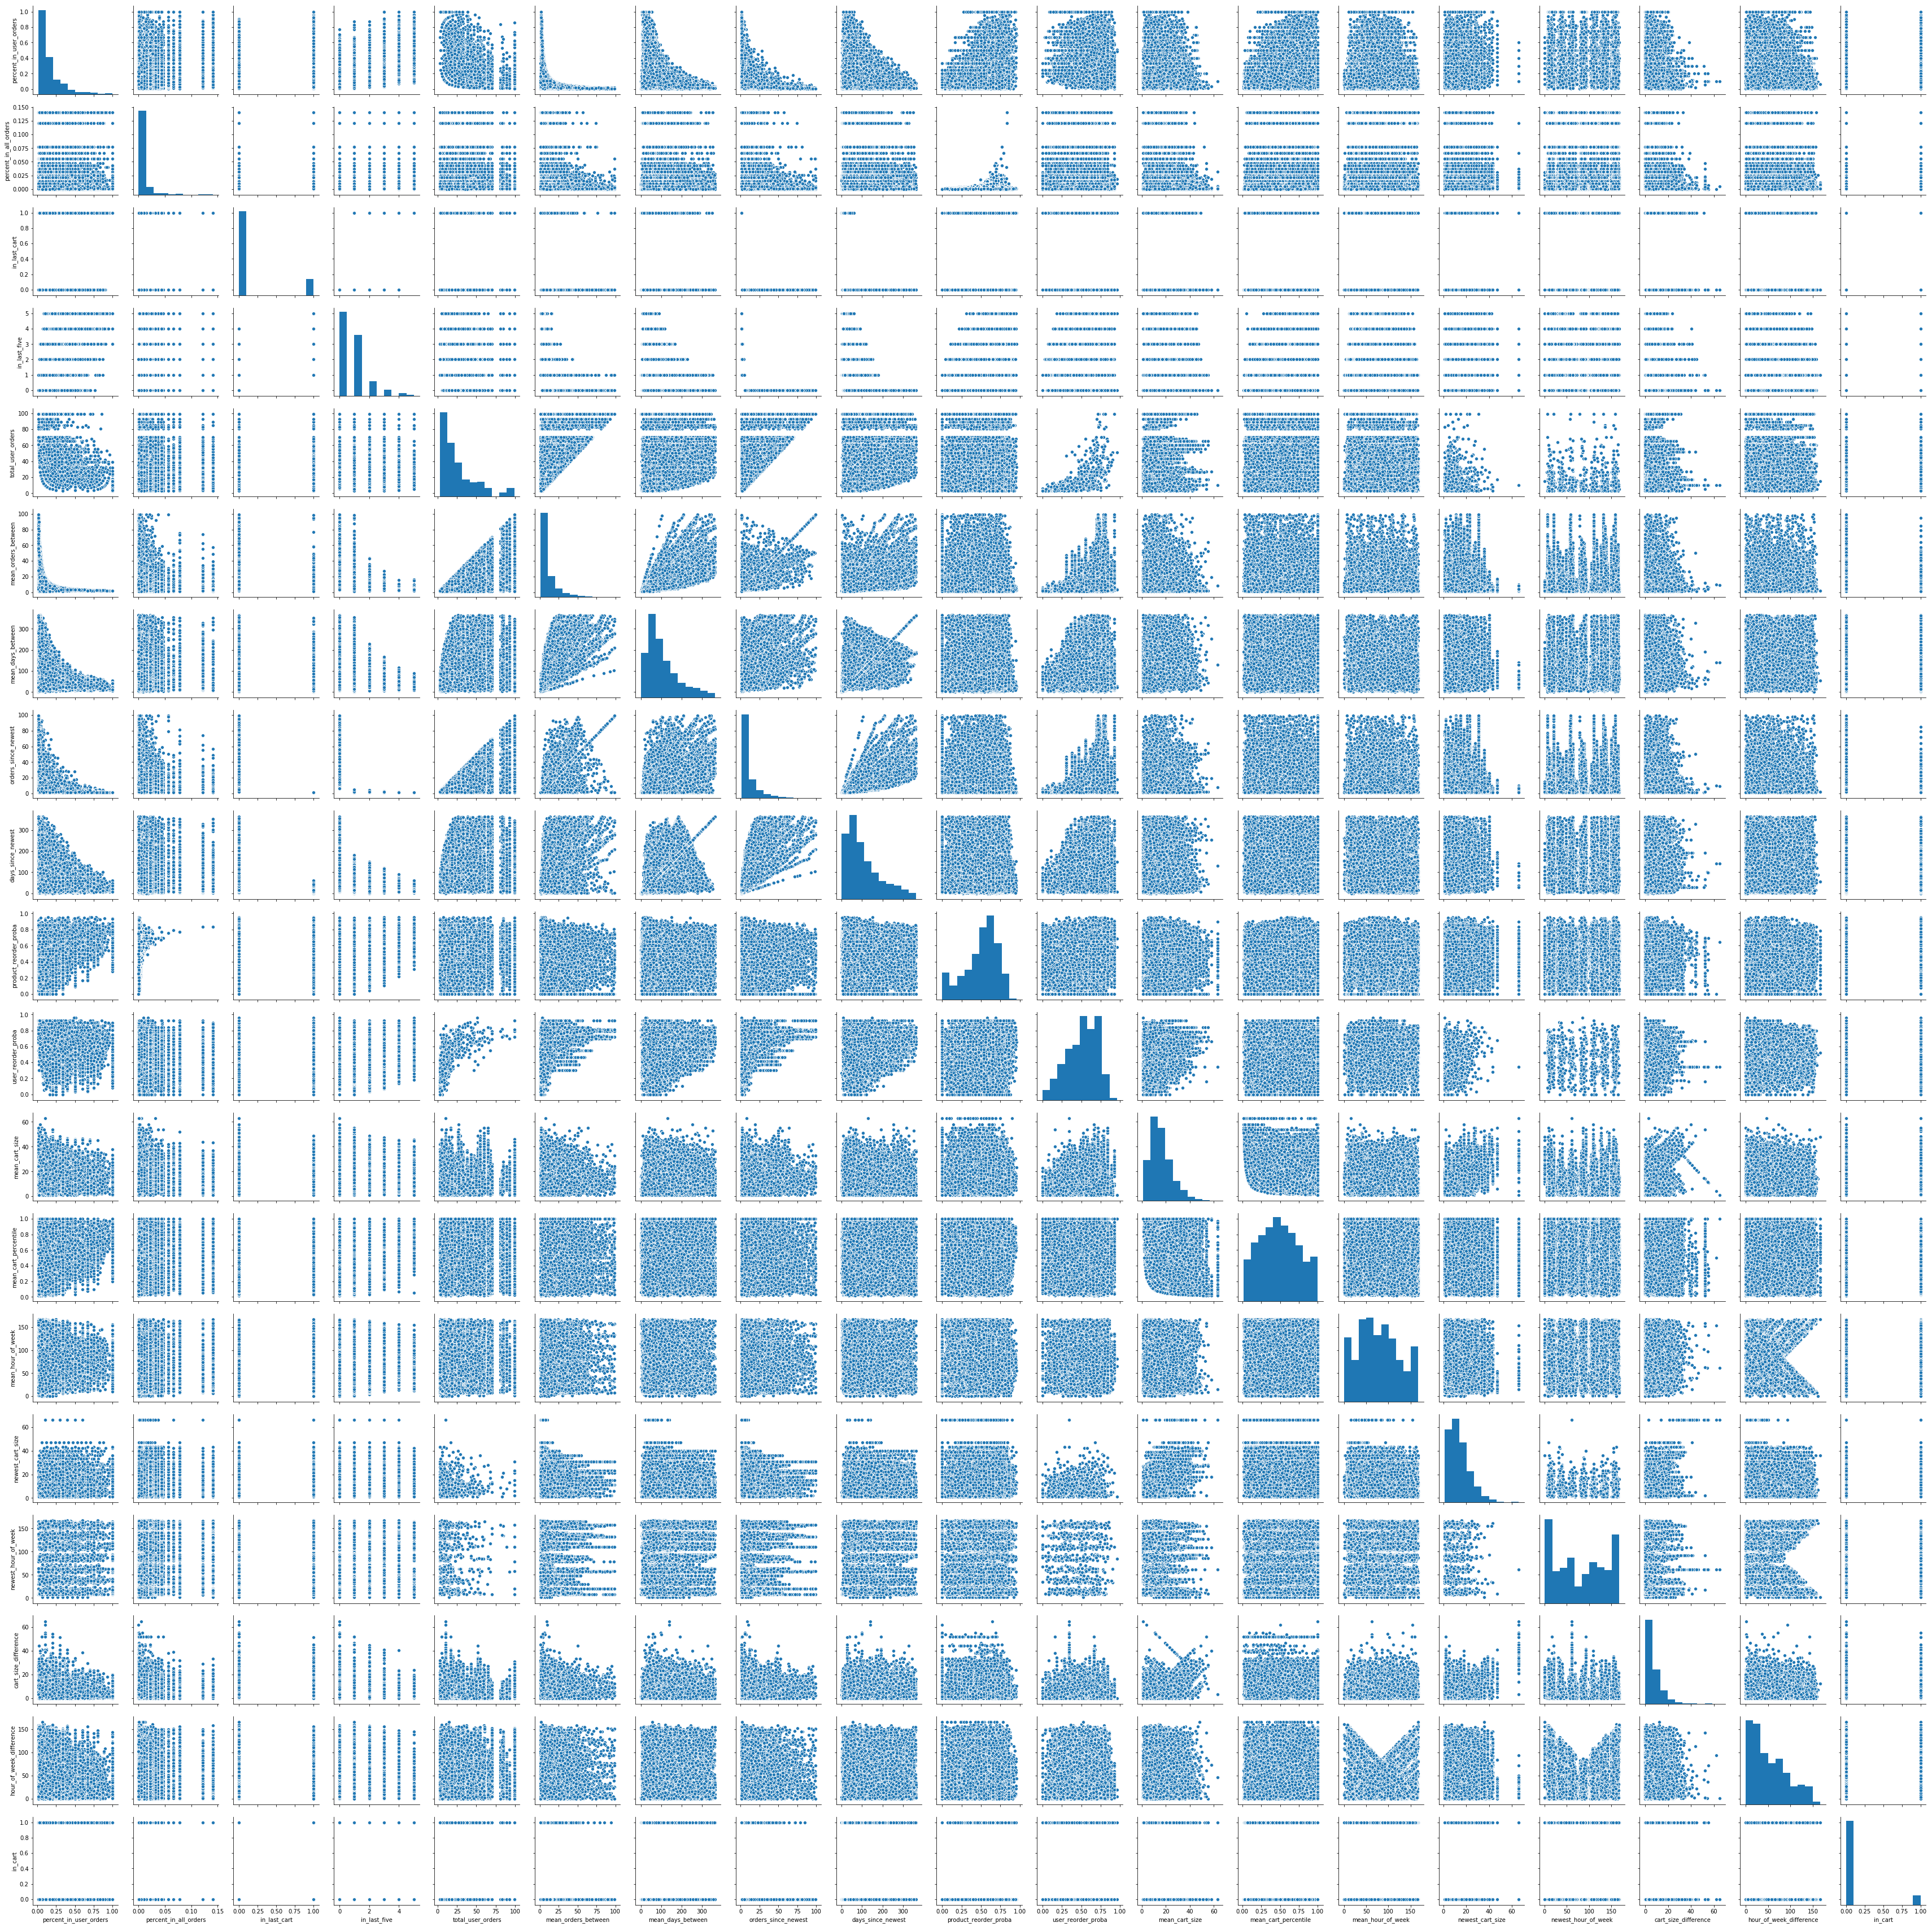

In [29]:
plt.figure(figsize=(20,20))
sns.pairplot(cv.get_df_folds()[0],
             #hue='in_cart',
             #plot_kws=dict(alpha=.1, edgecolor='none')
            );

### Oversampling (Inactive)
Only significantly improved Logistic Regression
* Logistic = .23 to .35
* KNN = .24 to .29
* Random Forest = .24 to .27
* xgboost = .29 to .32

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_neg, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(ratio=ratio, random_state=29)    
X_train, y_train = ROS.fit_sample(X_train, y_train)

### Generic Threshold Adjustment Function

In [29]:
def adjust_threshold(model, X, threshold=.5):
    return (model.predict_proba(X)[:, 1] >= threshold).astype(int)

### Baseline Logistic Regression

In [33]:
def optimize_logistic_c(X_train, y_train, X_val, y_val):
    max_c = max_score = max_model = 0
    for c in range(-3, 6):
        c_val = 10 ** c
        model = LogisticRegression(C=c_val, solver='lbfgs', multi_class='auto', max_iter=200)
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_c = c_val
            max_score = score
            max_model = model
            
    print(f'C = {max_c} yields the highest score: {max_score}')
    return max_model

In [ ]:
lr = optimize_logistic_c(X_train, y_train, X_val, y_val)

In [121]:
y_pred = lr.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.28006628787878785, 0.6051150895140665, 0.18219621130448174)

In [35]:
y_adj = adjust_threshold(lr, X_val, .15)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.42703742784433, 0.35766271574131836, 0.5298013245033113)

var_to_pickle(y_val, 'temp/actual.pk')
var_to_pickle(y_adj, 'temp/lgr_pred.pk')

In [30]:
cv.fit(LogisticRegression(C=10, solver='lbfgs', multi_class='auto', max_iter=600))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [31]:
cv.score(f1_score), cv.score(precision_score), cv.score(recall_score)

(0.28700083348627753, 0.5965874341584848, 0.18904878770327604)

In [42]:
cv.score(f1_score, .17)

0.42636382922516897

### Baseline xgboost

In [86]:
gbm = xgb.XGBClassifier(n_estimators=30000,
                        max_depth=3,
                        objective="binary:logistic",
                        learning_rate=.5, 
                        subsample=.08,
                        min_child_weight=.5,
                        colsample_bytree=.8)
cv.fit(gbm)

In [87]:
cv.score(f1_score), cv.score(precision_score), cv.score(recall_score)

(0.32676590334628514, 0.5954280421440284, 0.22517595495333653)

In [98]:
cv.score(f1_score, .21)

0.44409054467643183

### Baseline Random Forest Classifier

In [44]:
cv.fit(RandomForestClassifier(n_estimators=10, n_jobs=-1))

In [45]:
cv.score(f1_score), cv.score(precision_score), cv.score(recall_score)

(0.27443107591332366, 0.565046728358764, 0.18130555640996943)

In [52]:
cv.score(f1_score, .28)

0.3938146787684489

### Baseline KNN Classifier

In [41]:
def optimize_knn(X_train, y_train, X_val, y_val, max_iter=20):
    max_k = max_score = max_model = 0
    for k in range(1, max_iter+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_k = k
            max_score = score
            max_model = model
            
    print(f'k = {max_k} yields the highest score: {max_score}')
    return max_model

In [542]:
knn = optimize_knn(X_train, y_train, X_val, y_val)

k = 3 yields the highest score: 0.2850412249705536


In [543]:
y_pred = knn.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.2850412249705536, 0.39296346414073074, 0.2236254427845372)

In [544]:
y_adj = adjust_threshold(knn, X_val, .17)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.31197459368578373, 0.22387559487901335, 0.5144001232096104)